## Todo:

- update 'root_cause_discovery_high_dimensional' function to return final root cause score. 
- After that we can do simulations in high-dim settings (p=1000, n=300) to justify our real data results make sense (even though there are latent variable issue etc)
  
- Change name 'root_cause_discovery_one_subject_all_perm' to 'root_cause_discovery_main' <font color="blue">(done)</font>

- Change the function 'root_cause_discovery_one_subject_all_perm' so that there is no need to decide threshold. <font color="blue">(done)</font>
- After that we can do simulations in low-dim settings (p=100, n=300).

- Address small issues in 'root_cause_discovery_one_subject_all_perm' <font color="blue">(done)</font>

- Change variable names to make them consistency: e.g., X_obs and Xobs <font color="blue">(done)</font>

### This file is used as a test for later formal/extensive simulations

### Generate data by 

X <- mu_x+ BX +error + delta, 

or

X = (I-B)^{-1}* (mu_x + error + delta), 

with different kinds of B.

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import networkx as nx # draw DAG
from post_translation_code import  *
from simulation_setting_func import  *

In [2]:
import matplotlib.pyplot as plt
from collections import Counter

def draw_hist(list1, list2, label1, label2, bar_width_para=5):
    # Count the frequency of each integer in the lists
    counter1 = Counter(list1)
    counter2 = Counter(list2)
    
    # Combine keys from both counters
    all_elements = list(set(counter1.keys()).union(set(counter2.keys())))
    all_elements.sort()  # Sort elements for better visualization
    
    # Extract counts, ensuring all_elements order
    counts1 = [counter1[element] for element in all_elements]
    counts2 = [counter2[element] for element in all_elements]

    # Determine the x-axis range and calculate bar width dynamically
    x_range = max(all_elements) - min(all_elements) + 1  # Adding 1 to ensure a non-zero range
    num_elements = len(all_elements)
    bar_width = x_range / (num_elements * bar_width_para)  # Adjust the denominator for desired spacing
    
    # Define the positions of the bars
    r1 = np.arange(len(all_elements))
    r2 = [x + bar_width for x in r1]

    # Create the bar plot
    plt.figure(figsize=(10, 6))
    
    plt.bar(r1, counts1, color='skyblue', width=bar_width, edgecolor='grey', label=label1)
    plt.bar(r2, counts2, color='lightgreen', width=bar_width, edgecolor='grey', label=label2)
    
    # Add labels
    plt.xlabel('Rank of the root cause')
    plt.ylabel('Frequency')
    plt.ylim(0, max(counts1 + counts2)*(1+0.1))

    plt.xticks([r + bar_width/2 for r in range(len(all_elements))], all_elements)
    
    # Set x-axis range
    plt.xlim(min(r1) - bar_width, max(r2) + bar_width)
    
    plt.legend()
    plt.show()

### 1. Random DAG case

[  4.905   4.564   5.152   7.647  14.698   9.125  21.893  17.604   5.566
  13.407  37.418  10.245  30.035  49.226  50.248  24.614  34.146 201.525
 279.998 275.458]
[12.626 16.356 13.574 14.506  7.947 15.368  8.76   5.849 10.19  11.859
  5.946 10.182 17.501 14.521  8.966 18.23   8.029  8.328 16.518 12.813]
[12.626 16.203 14.858 14.454  9.489 13.598 10.109  7.684 11.492 12.846
  7.587 11.009 18.944 15.367 10.253 18.907  9.092  9.485 17.621 13.864]


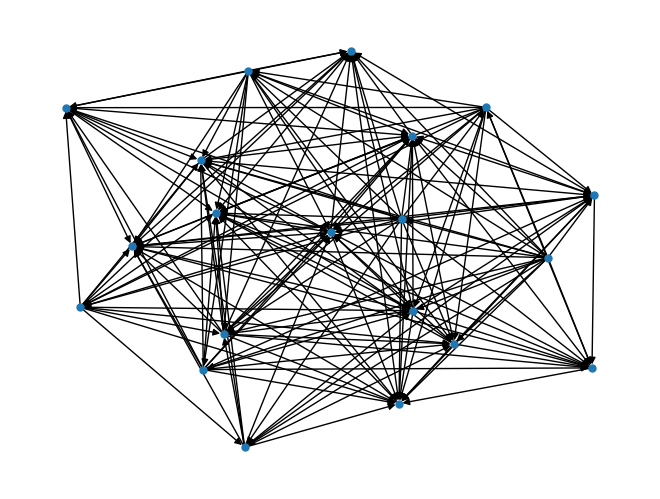

In [3]:
np.random.seed(2024)

############## Generate b, B and sigma2_error used in the SEM
p = 20
s_B = 0.8
B_value_min = -1
B_value_max = 1

b = np.random.uniform(-5,5,p)  # intercept

B_unscaled = B_random(p, s_B, B_value_min, B_value_max)

################ Rescale B, but keep its support, so that the variance of X is close to the given one 
err_min = 1
err_max = 5
var_X_min = 5
var_X_max = 20

sigma2_error_raw = np.random.uniform(err_min, err_max, p) # rep(var_error,p) # do not make error variance the same!
var_X_design = np.random.uniform(var_X_min, var_X_max, p)  # preset variance of X we want to get based on the SEM
B_scaled, sigma2_error_new = rescale_B_func(B_unscaled, var_X_design, sigma2_error_raw, tol=2, step_size=0.1, max_count=500)

# # check that we indeed make the variance of X similar to the preset one
I = np.identity(p)
# variance of X based on B_raw

var_X_raw = np.diag( np.dot( linalg.solve(I - B_unscaled, np.diag(sigma2_error_raw)), linalg.inv(I - B_unscaled).T ) )
var_X_new = np.diag( np.dot( linalg.solve(I - B_scaled, np.diag(sigma2_error_new)), linalg.inv(I - B_scaled).T ) )

print(np.round(var_X_raw,3))
print(np.round(var_X_new,3))
print(np.round(var_X_design,3))

# print(np.round(sigma2_error_raw,3))
# print(np.round(sigma2_error_new,3))

# Permute B and sigma2_error so that they are not in the causal ordering
ordering = np.random.permutation(np.arange(p))

Permut_mat = np.eye(p)[ordering]  
B = Permut_mat @ B_scaled @ Permut_mat.T 
sigma2_error = np.diag(sigma2_error_new[ordering])

G = nx.DiGraph(B!=0)
nx.draw_kamada_kawai(G, with_labels=False, node_size=25)

### Implement our method based on the simulated data

In [4]:
n = 200
m = 300
int_mean = 10
int_sd = 1

X_obs, X_int_all, RC = generate_data(n, m, p, B, sigma2_error, b, int_mean, int_sd)
print(X_obs.shape, X_int_all.shape)

(200, 20) (300, 20)


In [5]:
Zscores = zscore(X_obs, X_int_all)
#print(np.round(Zscores, 1))
max_index_Zscore = [np.argmax(Zscores[i,:]) for i in range(Zscores.shape[0])]

In [6]:
thresholds = np.arange(0.1, 5, 0.2)
RC_scores_chol = np.zeros((X_int_all.shape))
for i, X_int in tqdm(enumerate(X_int_all)):
    RC_scores_chol[i,:] = root_cause_discovery_main(X_obs, X_int, thresholds, nshuffles=5, verbose=False)

#print(np.round(RC_scores_chol, 1))
max_index_Chol = [np.argmax(RC_scores_chol[i,:]) for i in range(RC_scores_chol.shape[0])]

300it [01:18,  3.83it/s]


In [7]:
# a quick look at how for how many interventional smaples each method sucessfully find the RC 
num_success_Zscore = sum(x == y for x, y in zip(max_index_Zscore, RC))
num_success_Chol = sum(x == y for x, y in zip(max_index_Chol, RC))
print(num_success_Chol, num_success_Zscore)

# df = pd.DataFrame({"RC":RC, "Zscore": max_index_Zscore, "Chol": max_index_Chol})
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
# print(df.to_string(index=False))

258 196


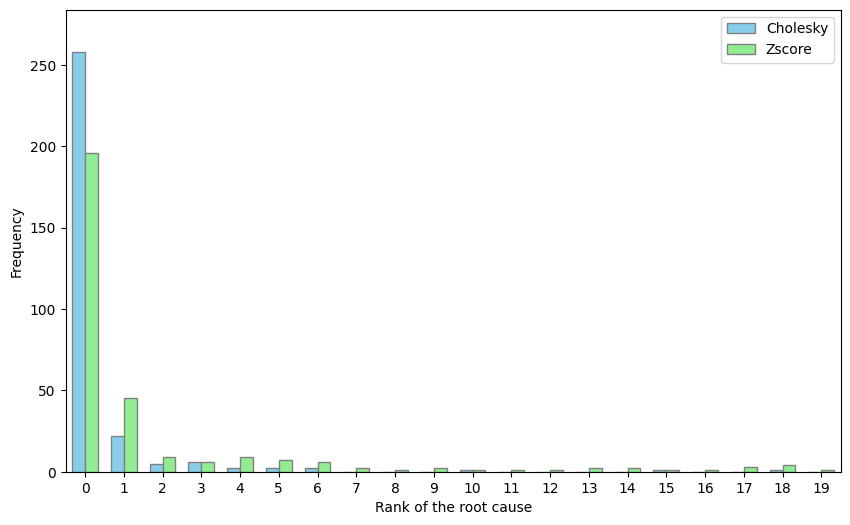

In [8]:
RC_rank_Zscore = [np.sum(Zscores[i,RC[i]] < Zscores[i,:]) 
 for i in range(Zscores.shape[0])]

RC_rank_Chol = [np.sum(RC_scores_chol[i,RC[i]] < RC_scores_chol[i,:]) 
 for i in range(RC_scores_chol.shape[0])]

draw_hist(RC_rank_Chol, RC_rank_Zscore, 'Cholesky', 'Zscore', bar_width_para=3)

#### 2. Hub DAG case: same simulation as above but using another DAG

[   4.    5.    5.    4.    5.    8.   12.   24.   19.  100.   29.   67.
  196.  203.   85.    2.    4.    5.    8.   14.   16.   10.    8.   40.
   21.   27.   47.  146.   80.  160.   83.  273.    2.   47.   13.  118.
   13.   65.  177.  638.  171.  448.  107.    9.  426.  125.  282.  236.
  210.  733. 1900.  196.]
[13.  8. 12.  9.  8. 10. 12.  9.  7.  5. 12. 15.  8. 10. 11.  8.  5. 18.
  5. 18. 17. 17.  9.  6.  8.  6.  6. 14.  8. 17.  6. 14. 18.  7. 20. 11.
 18.  7.  7.  6. 10. 19.  9. 18. 12. 18. 13. 11.  9. 12.  5. 12.]
[13.  9. 13.  9.  8. 11. 13. 10.  8.  5. 11. 16.  8.  9. 12.  8.  5. 18.
  5. 19. 17. 17.  9.  7.  8.  7.  5. 13.  9. 18.  5. 15. 19.  8. 19. 11.
 17.  6.  7.  6.  9. 19. 10. 18. 12. 19. 13. 11.  9. 13.  6. 13.]


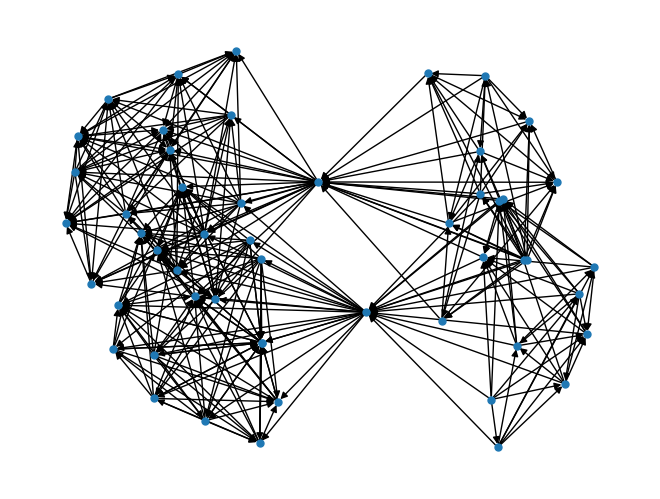

In [3]:
np.random.seed(2024)

### Parameters for B_hub
num_hub = 2 # same number of upper and lower blocks
s_B = 0.8
B_value_min = -1
B_value_max = 1

size_up_block = 15
size_low_block = 10
intersect_prop = 0.3
p = num_hub + num_hub * (size_up_block + size_low_block)
f"{p=}"

b = np.random.uniform(-5,5,p)  # intercept

B_unscaled = B_hub_func(num_hub, size_up_block, size_low_block, intersect_prop, s_B, B_value_min, B_value_max)

################ Rescale B, but keep its support, so that the variance of X is close to the given one 
err_min = 1
err_max = 5
var_X_min = 5
var_X_max = 20

sigma2_error_raw = np.random.uniform(err_min, err_max, p) # rep(var_error,p) # do not make error variance the same!
var_X_design = np.random.uniform(var_X_min, var_X_max, p)  # preset variance of X we want to get based on the SEM
B_scaled, sigma2_error_new = rescale_B_func(B_unscaled, var_X_design, sigma2_error_raw, tol=1, step_size=0.1, max_count=1000)

# # check that we indeed make the variance of X similar to the preset one
I = np.identity(p)
# variance of X based on B_raw
var_X_raw = np.diag( np.dot( linalg.solve(I - B_unscaled, np.diag(sigma2_error_raw)), linalg.inv(I - B_unscaled).T ) )
var_X_new = np.diag( np.dot( linalg.solve(I - B_scaled, np.diag(sigma2_error_new)), linalg.inv(I - B_scaled).T ) )

print(np.round(var_X_raw))
print(np.round(var_X_new))
print(np.round(var_X_design))

# print(np.round(sigma2_error_raw,3))
# print(np.round(sigma2_error_new,3))

# Permute B and sigma2_error so that they are not in the causal ordering
ordering = np.random.permutation(np.arange(p))

Permut_mat = np.eye(p)[ordering]  
B = Permut_mat @ B_scaled @ Permut_mat.T 
sigma2_error = np.diag(sigma2_error_new[ordering])

G = nx.DiGraph(B!=0)
nx.draw_kamada_kawai(G, with_labels=False, node_size=25)

In [4]:
n = 200
m = 300
int_mean = 10
int_sd = 1
X_obs, X_int_all, RC = generate_data(n, m, p, B, sigma2_error, b, int_mean, int_sd)
print(X_obs.shape, X_int_all.shape)

(200, 52) (300, 52)


In [5]:
Zscores = zscore(X_obs, X_int_all)
#print(np.round(Zscores, 1))
max_index_Zscore = [np.argmax(Zscores[i,:]) for i in range(Zscores.shape[0])]

In [6]:
thresholds = np.arange(0.1, 5, 0.2)
RC_scores_chol = np.zeros((X_int_all.shape))
for i, X_int in tqdm(enumerate(X_int_all)):
    RC_scores_chol[i,:] = root_cause_discovery_main(X_obs, X_int, thresholds, nshuffles=5, verbose=False)

#print(np.round(RC_scores_chol, 1))
max_index_Chol = [np.argmax(RC_scores_chol[i,:]) for i in range(RC_scores_chol.shape[0])]

300it [07:01,  1.41s/it]


In [7]:
# a quick look at how for how many interventional smaples each method sucessfully find the RC 
num_success_Zscore = sum(x == y for x, y in zip(max_index_Zscore, RC))
num_success_Chol = sum(x == y for x, y in zip(max_index_Chol, RC))
print(num_success_Chol, num_success_Zscore)

# df = pd.DataFrame({"RC":RC, "Zscore": max_index_Zscore, "Chol": max_index_Chol})
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
# print(df.to_string(index=False))

229 163


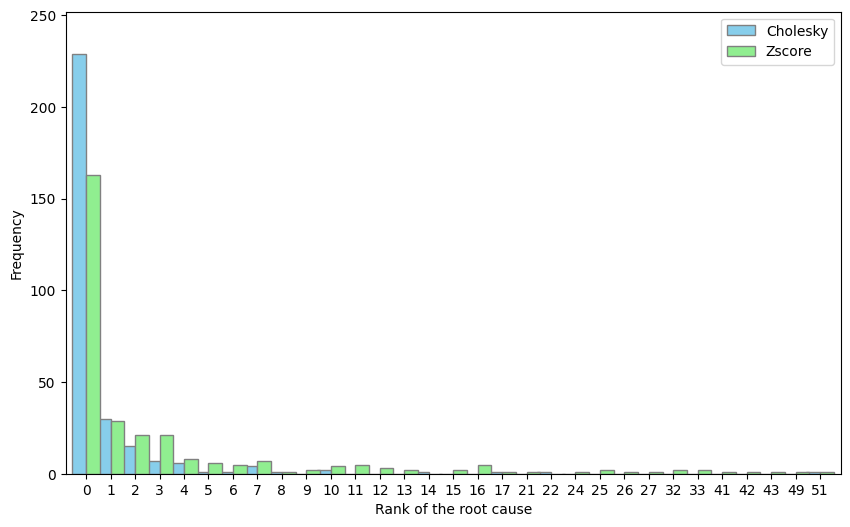

In [8]:
RC_rank_Zscore = [np.sum(Zscores[i,RC[i]] < Zscores[i,:]) 
 for i in range(Zscores.shape[0])]

RC_rank_Chol = [np.sum(RC_scores_chol[i,RC[i]] < RC_scores_chol[i,:]) 
 for i in range(RC_scores_chol.shape[0])]

draw_hist(RC_rank_Chol, RC_rank_Zscore, 'Cholesky', 'Zscore', bar_width_para=3)

### 3. High-dimensional setting

In [ ]:
np.random.seed(2024)

############## Generate b, B and sigma2_error used in the SEM
p = 500
s_B = 0.3
B_value_min = -1
B_value_max = 1

b = np.random.uniform(-5,5,p)  # intercept

B_unscaled = B_random(p, s_B, B_value_min, B_value_max)

################ Rescale B, but keep its support, so that the variance of X is close to the given one 
err_min = 1
err_max = 5
var_X_min = 5
var_X_max = 20

sigma2_error_raw = np.random.uniform(err_min, err_max, p) # rep(var_error,p) # do not make error variance the same!
var_X_design = np.random.uniform(var_X_min, var_X_max, p)  # preset variance of X we want to get based on the SEM
B_scaled, sigma2_error_new = rescale_B_func(B_unscaled, var_X_design, sigma2_error_raw, tol=1, step_size=0.1, max_count=500)

# # check that we indeed make the variance of X similar to the preset one
I = np.identity(p)
# variance of X based on B_raw

var_X_raw = np.diag( np.dot( linalg.solve(I - B_unscaled, np.diag(sigma2_error_raw)), linalg.inv(I - B_unscaled).T ) )
var_X_new = np.diag( np.dot( linalg.solve(I - B_scaled, np.diag(sigma2_error_new)), linalg.inv(I - B_scaled).T ) )

print(np.round(var_X_raw,0))
print(np.round(var_X_new,0))
print(np.round(var_X_design,0))

# print(np.round(sigma2_error_raw,3))
# print(np.round(sigma2_error_new,3))

# Permute B and sigma2_error so that they are not in the causal ordering
ordering = np.random.permutation(np.arange(p))

Permut_mat = np.eye(p)[ordering]  
B = Permut_mat @ B_scaled @ Permut_mat.T 
sigma2_error = np.diag(sigma2_error_new[ordering])

# G = nx.DiGraph(B!=0)
# nx.draw_kamada_kawai(G, with_labels=False, node_size=25)

In [21]:
n = 100
m = 300
int_mean = 10
int_sd = 1

X_obs, X_int_all, RC = generate_data(n, m, p, B, sigma2_error, b, int_mean, int_sd)
print(X_obs.shape, X_int_all.shape)

(100, 500) (300, 500)


In [26]:
# performance of Zscore method
Zscores = zscore(X_obs, X_int_all)
#print(np.round(Zscores, 1))
max_index_Zscore = [np.argmax(Zscores[i,:]) for i in range(Zscores.shape[0])]

num_success_Zscore = sum(x == y for x, y in zip(max_index_Zscore, RC))

RC_rank_Zscore = [np.sum(Zscores[i,RC[i]] < Zscores[i,:]) 
 for i in range(Zscores.shape[0])]

print("m is", m, " Zscore has",num_success_Zscore,"successes")

m is 300  Zscore has 106 successes
